### This workbook generates analysis code and figures for the spatial synapses case study

This workbook begins with the spatial synapse spreadsheet, which was created based on the synapse data and mask.

In [1]:
import csv
import matplotlib
import time
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import ndio.remote.neurodata as neurodata

token_synapse = 'MP4merged'
channel_synapse = 'annotation'
nd = neurodata()
%matplotlib inline

font = {'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

In [2]:
# Load Data

filename = 'merged_mask_v5_layer23only_DSP.csv' # layer 23 mask
#filename = 'merged_mask_v6_layerall_DSP.csv' # more permissive all-layer mask
fields = [
    'xstart', 'ystart', 'zstart',
    'xstop', 'ystop', 'zstop', 'res',
    'total_pix', 'mask_core_pix', 'mask_fraction',
    'syn_count_unmasked', 'density', 'syn_count_total',
    'center_x', 'center_y', 'center_z', 'center_res'
]

raw = open(filename, 'r').readlines()
reader = csv.reader(raw)

data = [[float(col) for col in row] for row in reader]
data = np.asarray(data)

In [3]:
# data preprocessing and basic statistics
# we eliminate regions that have more than 75% masking to reduce spurrious counts

idx = np.where(data[:,9] < 0.75)

d_new = data[np.ravel(idx),:]

# how many blocks?
print np.shape(d_new)


# we eliminate outliers for our statistical test, but not for visualization

d_mean = np.mean(d_new[:,11])
d_std = np.std(d_new[:,11])

print d_mean
print d_std
print np.min(d_new[:,11])
print np.max(d_new[:,11])

print d_mean - 2*d_std
print d_mean + 2*d_std

(41630, 17)
1.41605769877
0.469545225761
0.0
4.505
0.476967247254
2.3551481503


In [4]:
# Density estimation for volume

# this may be slow to retrieve - uncomment to run query
len_ids = 11668787 # known
# ids = nd.get_ramon_ids(token_synapse,channel_synapse) 
# len_ids = len(ids) 

import skimage.morphology

im = nd.get_cutout('bock11', 'image', 0, 265, 0, 234, 2917, 4156, resolution=9)

# figure out how many values are in the data block, approximately, filling in black space 
im2 = im > 0
im3 = skimage.morphology.dilation(im2,skimage.morphology.ball(4))
im3 = skimage.morphology.erosion(im3,skimage.morphology.ball(4))

pix = np.sum(im > 0)
print pix

pix3 = np.sum(im3 > 0)
print pix3

print pix*(0.004*2**9)*(0.004*2**9)*0.045
print pix3*(0.004*2**9)*(0.004*2**9)*0.045

# this will visualize slices to qualitatively confirm the dilation
if False:
    import ndparse as ndp

    for i in range(0,1200,50):
        ndp.plot(im3,slice = i)
        ndp.plot(im,slice = i)
        

density_overall = 1.0*len_ids/(pix3*(0.004*2**9)*(0.004*2**9)*0.045)
print density_overall

40046661
45654239
7558554.16885
8616949.07646
1.35416687466


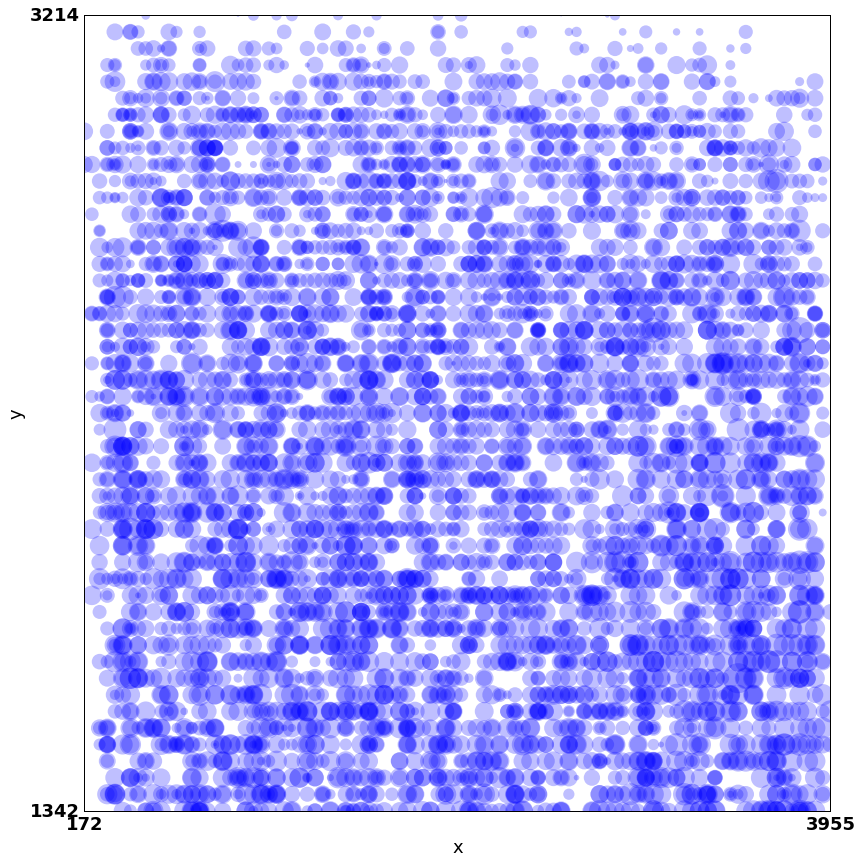

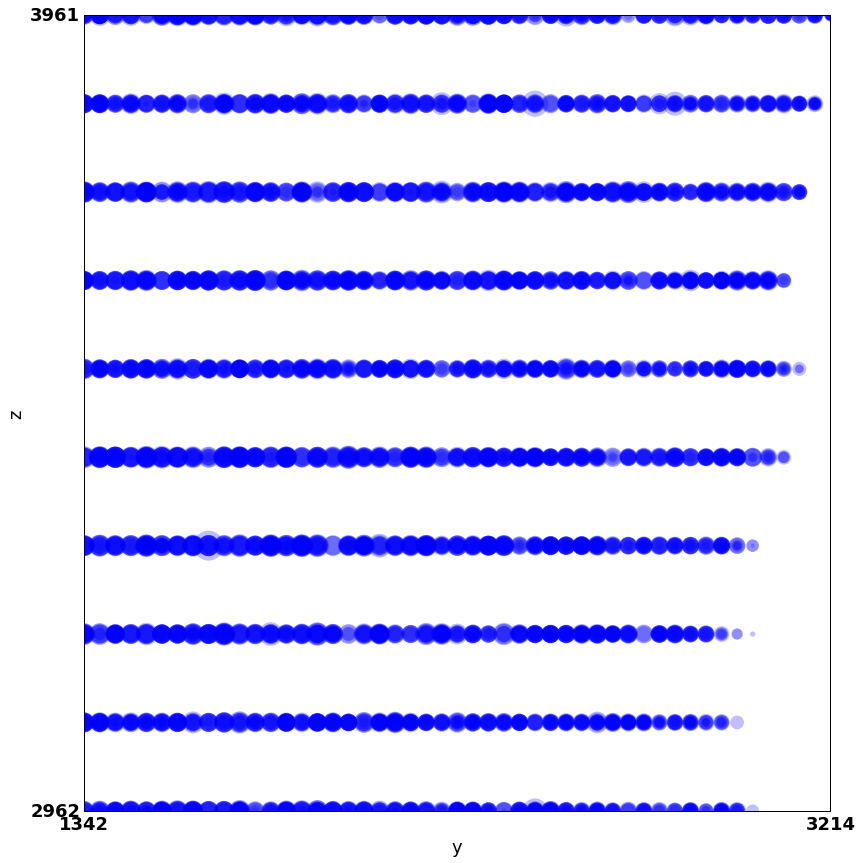

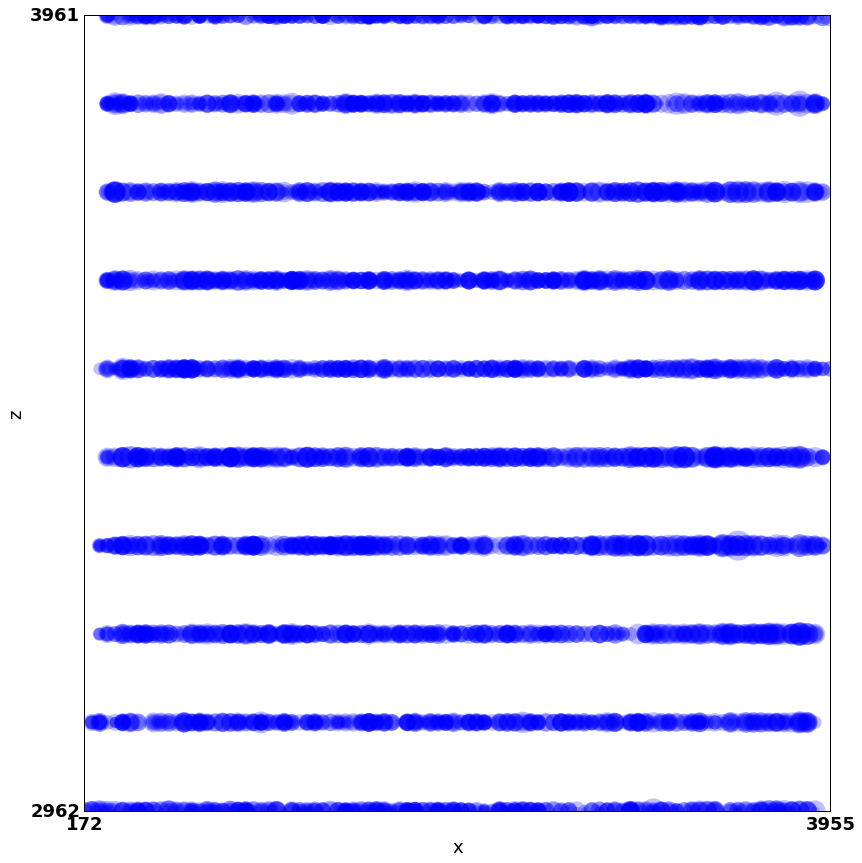

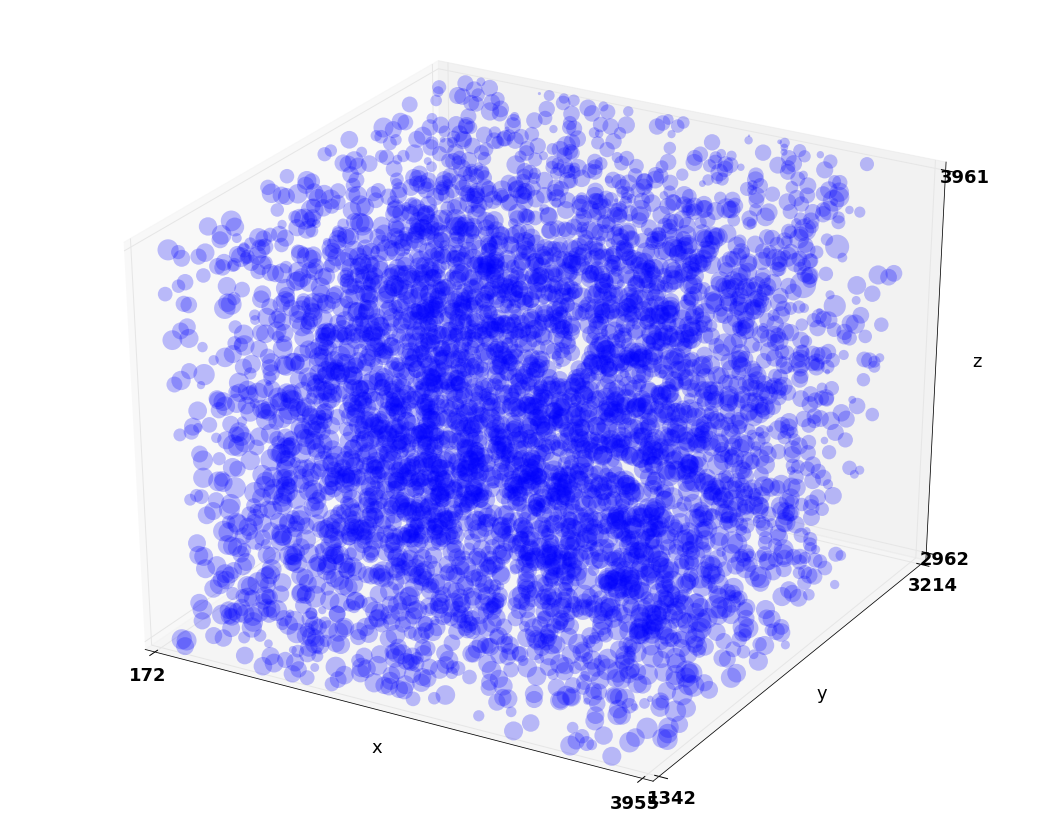

In [5]:
# Plots to visualize 2D and scatter views of the data

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import os
import sys
import csv

XLABEL =        "x"                                 # What to call the x axis
YLABEL =        "y"                                 # ...
ZLABEL =        "z"                                 # ...
SAVEDIR =       "figs"

def _perspective(xs, ys, zs, rs):
    """
    generates the perspective graph
    """
    fig = plt.figure('perspective',figsize=(15,12))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(xs, ys, zs, c='b', s=rs, alpha=0.25, linewidth=0)

    ax.set_xticks((np.min(xs), np.max(xs)))
    ax.set_yticks((np.min(ys), np.max(ys)))
    ax.set_zticks((np.min(zs), np.max(zs)))

    ax.set_xlabel(XLABEL)
    ax.set_ylabel(YLABEL)
    ax.set_zlabel(ZLABEL)
    ax.set_xlim((np.min(xs), np.max(xs)))
    ax.set_ylim((np.min(ys), np.max(ys)))
    ax.set_zlim((np.min(zs), np.max(zs)))
    plt.tight_layout()

    plt.savefig('{}/perspective.png'.format(SAVEDIR))


def _xy(xs, ys, zs, rs):
    _2d(xs, ys, rs, 'xy')

def _yz(xs, ys, zs, rs):
    _2d(ys, zs, rs, 'yz')

def _xz(xs, ys, zs, rs):
    _2d(xs, zs, rs, 'xz')

def _2d(xs, ys, rs, name):
    """
    Generates an arbitrary 2D projection. Specify which axis you want on the x,
    y axes, and give a radius list (if desired... otherwise, pass an integer).
    `name` is the `XY` pair to show as X and Y labels.
    """
    fig = plt.figure(name,figsize=(12,12))
    ax = fig.add_subplot(111)

    ax.scatter(xs, ys, c='b', s=rs, alpha=0.25, linewidth=0)

    ax.set_xticks((np.min(xs), np.max(xs)))
    ax.set_yticks((np.min(ys), np.max(ys)))
    ax.set_xlim((np.min(xs), np.max(xs)))
    ax.set_ylim((np.min(ys), np.max(ys)))
    plt.tight_layout()

    ax.set_xlabel(name[0])
    ax.set_ylabel(name[1])
    
    plt.savefig('{}/{}.png'.format(SAVEDIR, name))

npts = 5000
idx = np.random.permutation(len(d_new))[0:npts]

_xy(d_new[idx,0],d_new[idx,1],d_new[idx,2],d_new[idx,11]*200)

_yz(d_new[idx,0],d_new[idx,1],d_new[idx,2],d_new[idx,11]*200)

_xz(d_new[idx,0],d_new[idx,1],d_new[idx,2],d_new[idx,11]*200)

_perspective(d_new[idx,0],d_new[idx,1],d_new[idx,2],d_new[idx,11]*200)



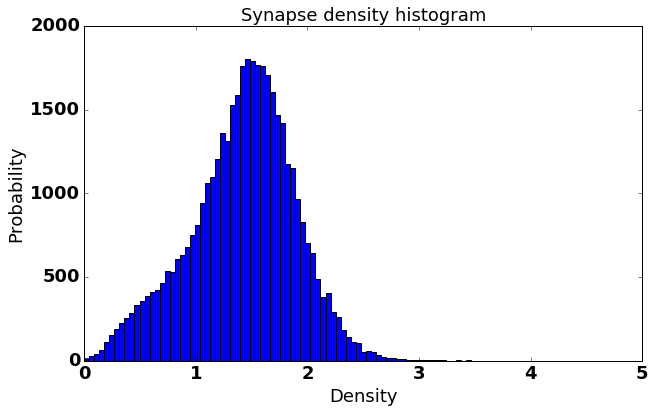

In [6]:
# Plot of histogram
name = 'histogram'
fig = plt.figure('histogram',figsize=(10,6))
n, bins, patches = plt.hist(d_new[:,11], 100)
#plt.plot(bins, y, 'r--')
plt.xlabel('Density')
plt.ylabel('Probability')
plt.title("Synapse density histogram", fontsize="18")
plt.savefig('{}/{}.png'.format(SAVEDIR, name))


/Users/graywr1/.conda/envs/ndpaper/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


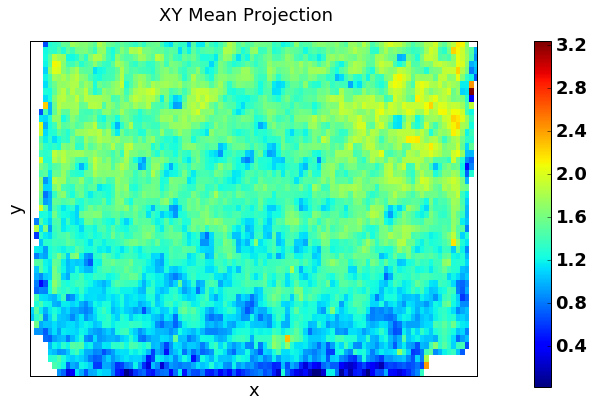

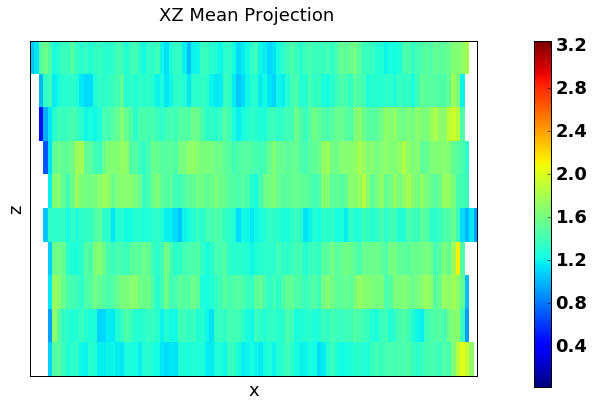

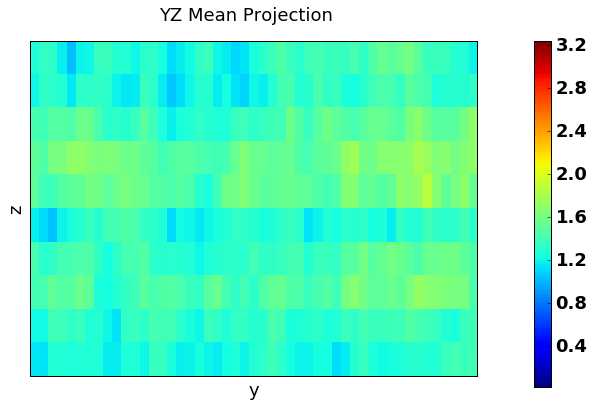

In [7]:
# Alternative density plots (really sum projection not max)

dv0 = np.unique(d_new[:,0])
dv1 = np.unique(d_new[:,1])
dv2 = np.unique(d_new[:,2])

mp = np.zeros([len(dv0),len(dv1)])
xx = 0
yy = 0
for d0 in dv0:
    yy = 0
    for d1 in dv1:
        idx = np.where((d_new[:,0] == d0) & (d_new[:,1] == d1))
        mp[xx,yy] = np.nanmean(d_new[idx,11])
        yy += 1
    xx += 1

mp1 = np.zeros([len(dv0),len(dv2)])
xx = 0
yy = 0
for d0 in dv0:
    yy = 0
    for d2 in dv2:
        idx = np.where((d_new[:,0] == d0) & (d_new[:,2] == d2))
        mp1[xx,yy] = np.nanmean(d_new[idx,11])
        yy += 1
    xx += 1

mp2 = np.zeros([len(dv1),len(dv2)])
xx = 0
yy = 0
for d1 in dv1:
    yy = 0
    for d2 in dv2:
        idx = np.where((d_new[:,0] == d1) & (d_new[:,2] == d2))
        mp2[xx,yy] = np.nanmean(d_new[idx,11])
        yy += 1
    xx += 1

mmin = np.nanmin([np.nanmin(mp),np.nanmin(mp1),np.nanmin(mp2)])
mmax = np.nanmax([np.nanmax(mp),np.nanmax(mp1),np.nanmax(mp2)])

# Plot each slice as an independent subplot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)# The vmin and vmax arguments specify the color limits
im = ax.imshow(mp.T, vmin=mmin, vmax=mmax,interpolation='nearest')

# Make an axis for the colorbar on the right side
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
fig.colorbar(im, cax=cax)
ax.set_aspect('auto')
ax.set_xlabel(XLABEL)
ax.set_ylabel(YLABEL)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.suptitle("XY Mean Projection", fontsize="18")
plt.savefig('{}/{}.png'.format(SAVEDIR, 'xy_proj'))

plt.show()

fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)# The vmin and vmax arguments specify the color limits
im = ax1.imshow(mp1.T, vmin=mmin, vmax=mmax,interpolation='nearest')

# Make an axis for the colorbar on the right side
cax1 = fig1.add_axes([1, 0.1, 0.03, 0.8])
fig1.colorbar(im, cax=cax1)
ax1.set_aspect('auto')
ax1.set_xlabel(XLABEL)
ax1.set_ylabel(ZLABEL)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
plt.suptitle("XZ Mean Projection", fontsize="18")
plt.savefig('{}/{}.png'.format(SAVEDIR, 'xz_proj'))

plt.show()

fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_subplot(111)# The vmin and vmax arguments specify the color limits
im = ax2.imshow(mp2.T, vmin=mmin, vmax=mmax,interpolation='nearest')

# Make an axis for the colorbar on the right side
cax2 = fig2.add_axes([1, 0.1, 0.03, 0.8])
fig2.colorbar(im, cax=cax2)
ax2.set_aspect('auto')
ax2.set_xlabel(YLABEL)
ax2.set_ylabel(ZLABEL)
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
plt.suptitle("YZ Mean Projection", fontsize="18")
plt.savefig('{}/{}.png'.format(SAVEDIR, 'yz_proj'))

plt.show()


In [8]:
# Chi-squared statistical test (using 10 histogram bins, considering only values +/- 2 std from mean.  clearly non-uniform)
# each bin is about 25 synapses "wide" informally, which seems like a reasonable division
import scipy.stats
s = d_new[:,11]
s_mean = np.mean(s)
s_std = np.std(s)
s1 = s[(s >= s_mean - 1*s_std) & (s <= s_mean + 1*s_std)]
s2 = s[(s >= s_mean - 2*s_std) & (s <= s_mean + 2*s_std)]
s3 = s[(s >= s_mean - 3*s_std) & (s <= s_mean + 3*s_std)]

print len(s2)

freq, edges = np.histogram(s2,10)

chisq, p_val = scipy.stats.chisquare(freq, f_exp = None, ddof=0, axis=0) 
#[500, 1800, 4800, 9200, 13600, 15200, 10200, 4700, 1500, 300]
print freq
print edges
print chisq
print('%.10f' % p_val)


39426
[1600 2210 2986 4587 6232 7402 6520 4444 2319 1126]
[ 0.477   0.6648  0.8526  1.0404  1.2282  1.416   1.6038  1.7916  1.9794
  2.1672  2.355 ]
11285.0703597
0.0000000000


5157
High Density Synapses...
9356
Synapse Density:   2.182


/Users/graywr1/.conda/envs/ndpaper/lib/python2.7/site-packages/numpy/ma/core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


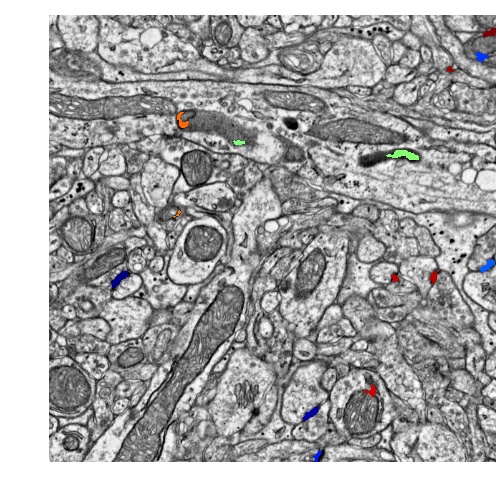

34428
Synapse Density:   2.041


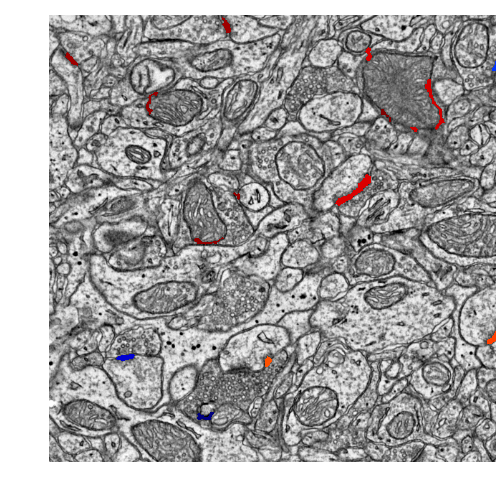

17849
Synapse Density:   2.277


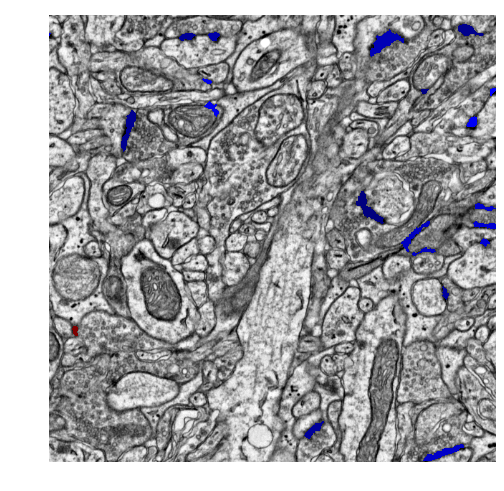

36584
Synapse Density:   2.067


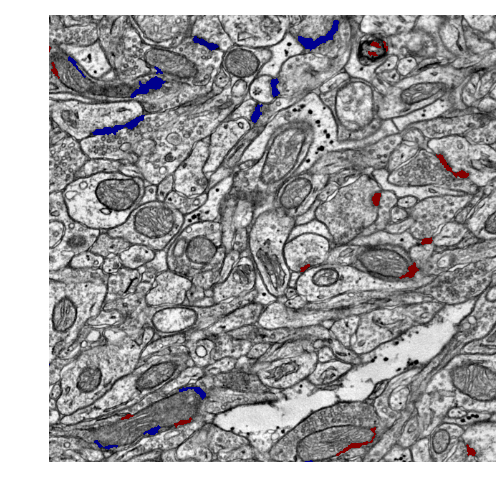

28601
Synapse Density:   2.091


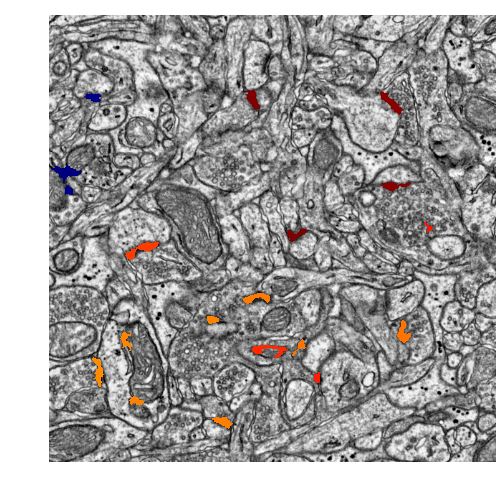

Medium Density Synapses...
31118
Synapse Density:   1.098


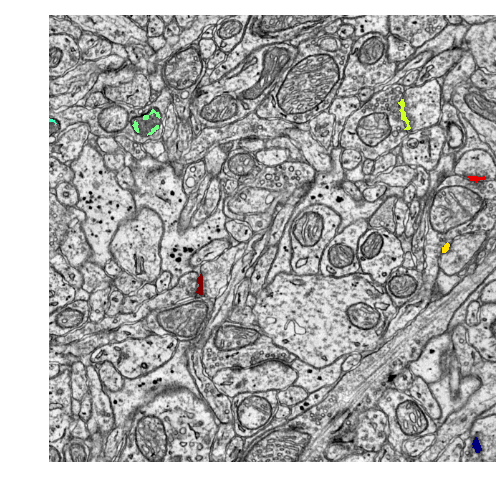

2823
Synapse Density:   1.469


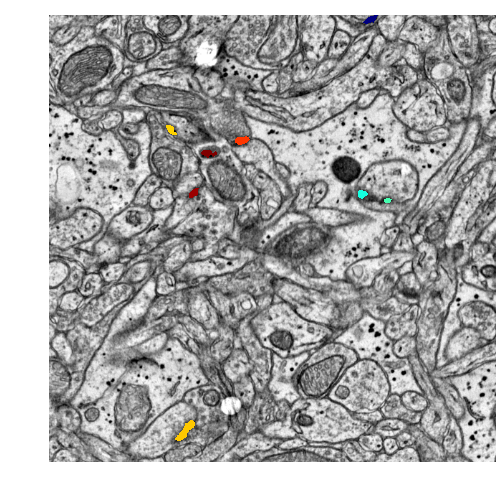

38899
Synapse Density:   1.597


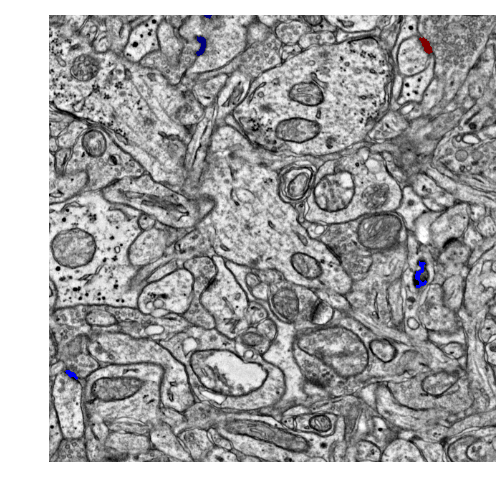

18216
Synapse Density:   1.166


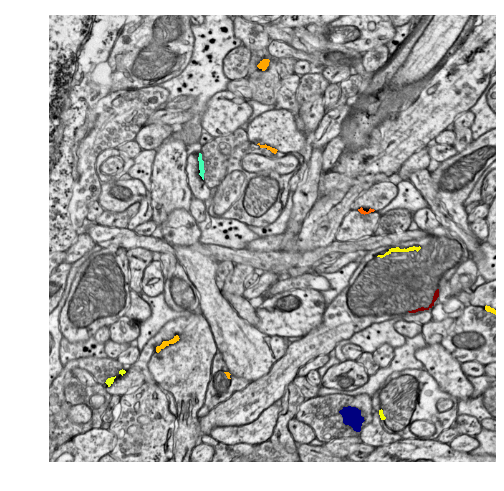

6773
Synapse Density:   1.828


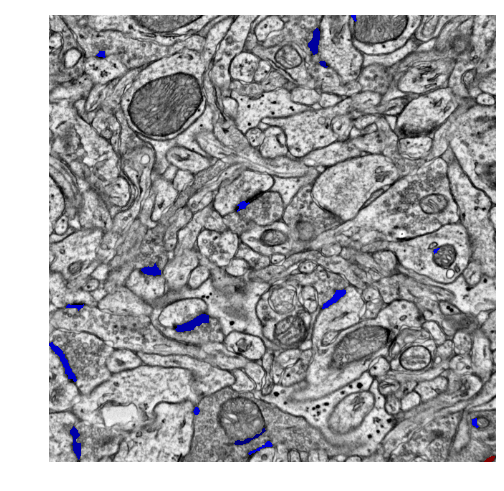

Low Density Synapses...
33695
Synapse Density:   0.819


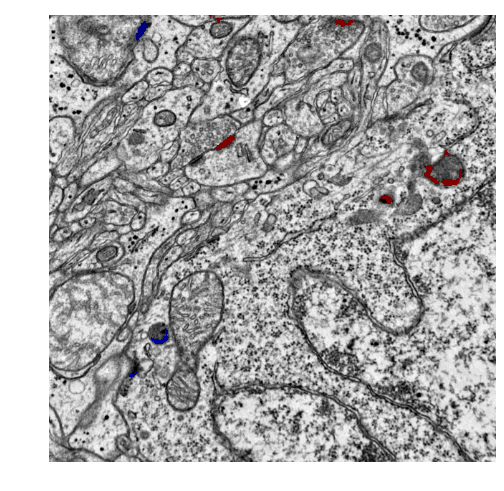

2051
Synapse Density:   0.756


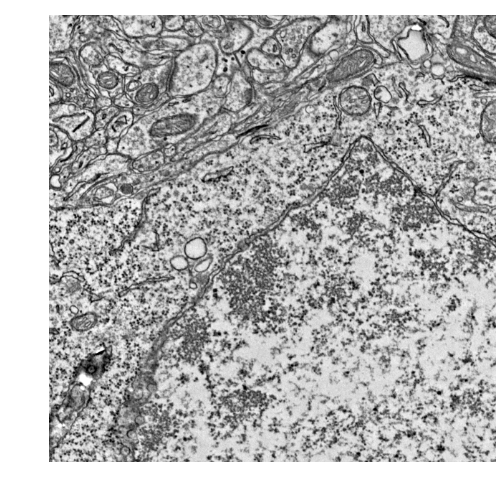

12792
Synapse Density:   0.735


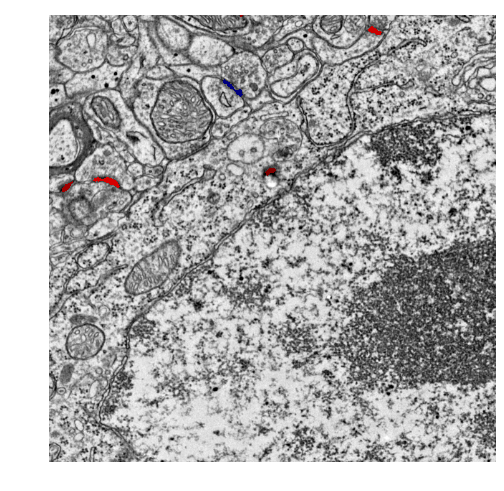

20330
Synapse Density:   0.792


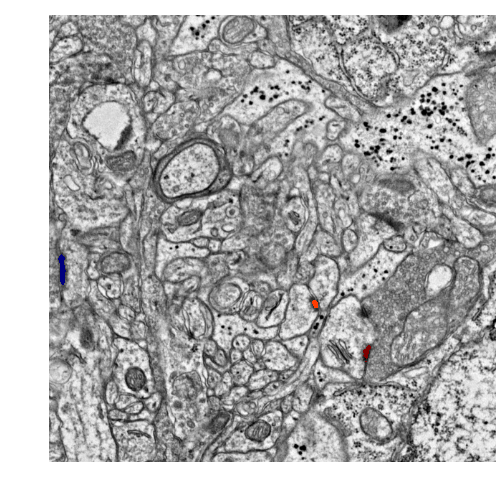

22508
Synapse Density:   0.856


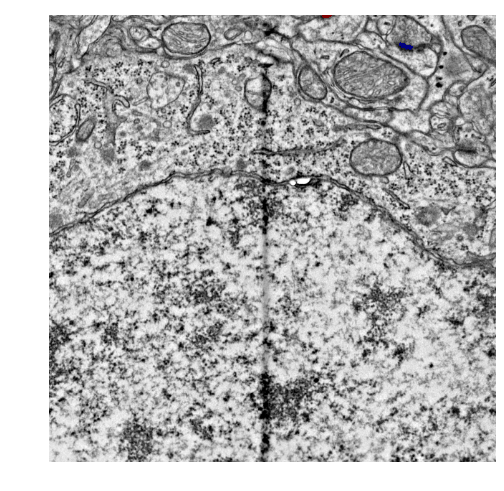

In [9]:
# Samples of high and low density images
nfig = 5 # Of each type

# find low and high samples
low_all = np.where((d_new[:,11] < d_mean - d_std) & (d_new[:,11] > d_mean - 2*d_std))[0]
high_all = np.where((d_new[:,11] > d_mean + d_std) & (d_new[:,11] < d_mean + 2*d_std))[0]
med_all = np.where((d_new[:,11] > d_mean - d_std) & (d_new[:,11] < d_mean + d_std))[0]
nlow =  len(low_all)
nhigh =  len(high_all)
nmed = len(med_all)

print nlow

# randomize 
low_idx = np.random.permutation(np.ravel(low_all))[0:nfig]
high_idx = np.random.permutation(np.ravel(high_all))[0:nfig]
med_idx = np.random.permutation(np.ravel(med_all))[0:nfig]

# High - here is +1 std

token_synapse = 'MP4merged'
channel_synapse = 'annotation'

token_mask = 'bock11_mask_v1'
channel_mask = 'mask'

from ndio.remote import neurodata as neurodata

nd = neurodata(chunk_threshold=2e9,suppress_warnings=True)

alph = 1
mask_flag = True
       
c = 0
print 'High Density Synapses...'
for x in high_idx:
    print x

    zslice = 55 #known

    xstart = int(d_new[x,0]*2**4)
    ystart = int(d_new[x,1]*2**4)
    zstart = int(d_new[x,2]+zslice)
    xstop = int(d_new[x,3]*2**4)
    ystop = int(d_new[x,4]*2**4)
    zstop = zstart+1
    resolution = 1
    image = 0 #start 
    while np.sum(np.ravel(image) == 0):
        syn = nd.get_cutout(token_synapse, channel_synapse, xstart, xstop, ystart, ystop, zstart, zstop, resolution=1)
        mask = nd.get_cutout(token_mask, channel_mask, xstart, xstop, ystart, ystop, zstart, zstop, resolution=1)
        image = nd.get_cutout('bock11', 'image', xstart, xstop, ystart, ystop, zstart, zstop, resolution=1)
        zstart += 1
        zstop += 1
        
    base_im = image
    anno_im = syn
    mask_im = mask

    fig = plt.figure(figsize=(8,8))
    plt.imshow(base_im[:,:,0].T, cmap='gray', interpolation='bilinear')
    plt.hold(True) 
    anno2 = np.asarray(anno_im, dtype='float')
    anno2[anno2 == 0] = np.nan  # zero out bg
    plt.imshow(anno2[:,:,0].T, cmap='jet', alpha=alph, interpolation='nearest')
    if mask_flag:
        mask2 = np.asarray(mask_im, dtype='float')
        mask2[mask2 == 0] = np.nan  # zero out bg
        plt.imshow(mask2[:,:,0].T, cmap='gray', alpha=alph, interpolation='nearest')
    plt.axis('off')
    #plt.title(fig_title)
    print 'Synapse Density:  ', str(d_new[x,11])
    plt.savefig('{}/{}.png'.format('samples', 'high_'+str(c).zfill(4)))

    if c < 5:
        plt.show()
    c += 1

c = 0
print 'Medium Density Synapses...'
for x in med_idx:
    print x
    zslice = 55 #known

    xstart = int(d_new[x,0]*2**4)
    ystart = int(d_new[x,1]*2**4)
    zstart = int(d_new[x,2]+zslice)
    xstop = int(d_new[x,3]*2**4)
    ystop = int(d_new[x,4]*2**4)
    zstop = zstart+1
    resolution = 1
    image = 0 #start 
    while np.sum(np.ravel(image) == 0):
        syn = nd.get_cutout(token_synapse, channel_synapse, xstart, xstop, ystart, ystop, zstart, zstop, resolution=1)
        mask = nd.get_cutout(token_mask, channel_mask, xstart, xstop, ystart, ystop, zstart, zstop, resolution=1)
        image = nd.get_cutout('bock11', 'image', xstart, xstop, ystart, ystop, zstart, zstop, resolution=1)
        zstart += 1
        zstop += 1
        
    base_im = image
    anno_im = syn
    mask_im = mask

    fig = plt.figure(figsize=(8,8))
    plt.imshow(base_im[:,:,0].T, cmap='gray', interpolation='bilinear')
    plt.hold(True) 
    anno2 = np.asarray(anno_im, dtype='float')
    anno2[anno2 == 0] = np.nan  # zero out bg
    plt.imshow(anno2[:,:,0].T, cmap='jet', alpha=alph, interpolation='nearest')
    if mask_flag:
        mask2 = np.asarray(mask_im, dtype='float')
        mask2[mask2 == 0] = np.nan  # zero out bg
        plt.imshow(mask2[:,:,0].T, cmap='gray', alpha=alph, interpolation='nearest')
    plt.axis('off')
    #plt.title(fig_title)
    print 'Synapse Density:  ', str(d_new[x,11])
    plt.savefig('{}/{}.png'.format('samples', 'medium_'+str(c).zfill(4)))

    if c < 5:
        plt.show()
    c += 1        
        
print 'Low Density Synapses...'
# Low - here is -1 std
c = 0
zslice = 55 #known

for x in low_idx:
    print x

    xstart = int(d_new[x,0]*2**4)
    ystart = int(d_new[x,1]*2**4)
    zstart = int(d_new[x,2]+zslice)
    xstop = int(d_new[x,3]*2**4)
    ystop = int(d_new[x,4]*2**4)
    zstop = zstart+1
    resolution = 1
    image = 0 #start 
    while np.sum(np.ravel(image) == 0):
        syn = nd.get_cutout(token_synapse, channel_synapse, xstart, xstop, ystart, ystop, zstart, zstop, resolution=1)
        mask = nd.get_cutout(token_mask, channel_mask, xstart, xstop, ystart, ystop, zstart, zstop, resolution=1)
        image = nd.get_cutout('bock11', 'image', xstart, xstop, ystart, ystop, zstart, zstop, resolution=1)
        zstart += 1
        zstop += 1
        
    base_im = image
    anno_im = syn
    mask_im = mask

    fig = plt.figure(figsize=(8,8))
    plt.imshow(base_im[:,:,0].T, cmap='gray', interpolation='bilinear')
    plt.hold(True) 
    anno2 = np.asarray(anno_im, dtype='float')
    anno2[anno2 == 0] = np.nan  # zero out bg
    plt.imshow(anno2[:,:,0].T, cmap='jet', alpha=alph, interpolation='nearest')
    if mask_flag:
        mask2 = np.asarray(mask_im, dtype='float')
        mask2[mask2 == 0] = np.nan  # zero out bg
        plt.imshow(mask2[:,:,0].T, cmap='gray', alpha=alph, interpolation='nearest')
    plt.axis('off')
    #plt.title(fig_title)
    #print "Last updated at:", time.ctime()
    plt.savefig('{}/{}.png'.format('samples', 'low_'+str(c).zfill(4)))

    print 'Synapse Density:  ', str(d_new[x,11])
    if c < 5:
        plt.show()
    c += 1


# Interactive 3D Plotting of Cubes

In [10]:
# find low and high samples

x = med_all[999] #index to explore - relatively slow (~0.5-1 minute) if you wish to explore the full cube

xstart = int(d_new[x,0]*2**4)
ystart = int(d_new[x,1]*2**4)
zstart = int(d_new[x,2])
xstop = int(d_new[x,3]*2**4)
ystop = int(d_new[x,4]*2**4)
zstop = int(d_new[x,5])
resolution = 1

token_synapse = 'MP4merged'
channel_synapse = 'annotation'

token_mask = 'bock11_mask_v1'
channel_mask = 'mask'

from ndio.remote import neurodata as neurodata

nd = neurodata(chunk_threshold=2e9,suppress_warnings=True)

syn = nd.get_cutout(token_synapse, channel_synapse, xstart, xstop, ystart, ystop, zstart, zstop, resolution=1)
mask = nd.get_cutout(token_mask, channel_mask, xstart, xstop, ystart, ystop, zstart, zstop, resolution=1)
image = nd.get_cutout('bock11', 'image', xstart, xstop, ystart, ystop, zstart, zstop, resolution=1)

Last updated at: Mon Jun 27 18:45:30 2016


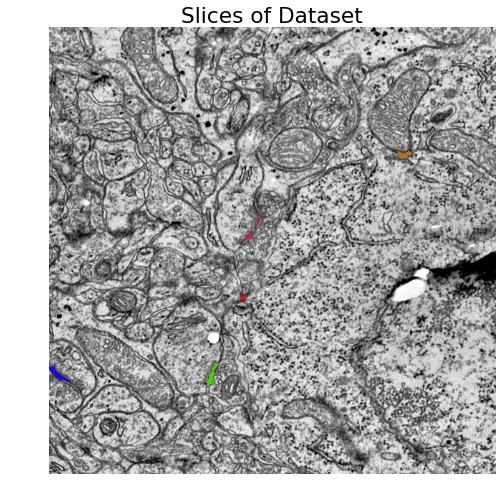

In [11]:
from ipywidgets import widgets
from IPython.display import display
from mpl_toolkits.mplot3d import axes3d
from collections import namedtuple

alpha = 0.7
slicez = 55
base_im = image
anno_im = syn
mask_im = mask
mask_flag = True
fig_title = 'Slices of Dataset'

def nav3dslices(zslice, alph, cmap, title=fig_title, mask=mask_flag):
    fig = plt.figure(figsize=(8,8))
    plt.imshow(base_im[:,:,zslice].T, cmap='gray', interpolation='bilinear')
    plt.hold(True) 
    anno2 = np.asarray(anno_im, dtype='float')
    anno2[anno2 == 0] = np.nan  # zero out bg
    plt.imshow(anno2[:,:,zslice].T, cmap=cmap, alpha=alph, interpolation='nearest')
    if mask:
        mask2 = np.asarray(mask_im, dtype='float')
        mask2[mask2 == 0] = np.nan  # zero out bg
        plt.imshow(mask2[:,:,zslice].T, cmap='gray', alpha=alph, interpolation='nearest')
    plt.axis('off')
    plt.title(fig_title)
    print "Last updated at:", time.ctime()
    plt.show()

cmaps = plt.colormaps()
zslice, alph, set_cmap = (widgets.IntSlider(description="Set zslice",
                                            min=0,
                                            max=base_im.shape[2]-1,
                                            value=slicez,
                                            step=1),
                           widgets.FloatSlider(description="Alpha Scaling", 
                                            min=0,
                                            max=1,
                                            value=alpha,
                                            step=0.01),
                           widgets.Dropdown(description="Annotation colourmap",
                                            options={str(c): c for c in cmaps},
                                            value='prism_r'))

set_slice = (widgets.FloatText(description="Set slice",
                               value=slicez))
dl = widgets.jsdlink((set_slice, 'value'), (zslice, 'value'))
display(set_slice)
w = widgets.interact(nav3dslices, zslice=zslice, alph=alph,cmap=set_cmap)

def on_slice_change(change):
    zslice.notify_change(change)
set_slice.observe(on_slice_change, names='value')